In [1]:
import torch
from torch import nn
import torchvision
import presets
import numpy as np
import calibration_utils

from torchvision.transforms.functional import InterpolationMode
from sklearn.metrics import  confusion_matrix
from matplotlib import pyplot as plt

In [2]:
device = 'cpu'
MODEL = 'mobilenet_v3_large'
NUM_CLASSES = 2
PATH = 'output/model_3.pth'

model = torchvision.models.get_model(MODEL, weights=None, num_classes=NUM_CLASSES)
state_dict = torch.load(PATH)
model.load_state_dict(state_dict['model'])
model.to(device)
None

In [3]:
args = state_dict["args"]
valdir = "data/val"
interpolation = InterpolationMode(args.interpolation)

In [4]:
preprocessing = presets.ClassificationPresetEval(
                crop_size=args.val_crop_size,
                resize_size=args.val_resize_size,
                interpolation=interpolation,
                backend=args.backend,
                use_v2=args.use_v2,
            )

dataset_test = torchvision.datasets.ImageFolder(
    valdir,
    preprocessing,
)
test_sampler = torch.utils.data.SequentialSampler(dataset_test)
data_loader = torch.utils.data.DataLoader(
        dataset_test, batch_size=args.batch_size, sampler=test_sampler, num_workers=args.workers, pin_memory=True
    )

In [5]:
criterion = nn.CrossEntropyLoss()

conf_scores, preds, gt = list(), list(), list()
with torch.inference_mode():
    for image, target in data_loader:
        image = image.to(device, non_blocking=True)
        target = target.to(device, non_blocking=True)
        output = model(image)
        # loss = criterion(output, target)
        conf_scores.append(torch.nn.functional.softmax(output, dim=1))
        preds.append(torch.argmax(output, dim=1))
        gt.append(target)

In [6]:
np_gt = np.concatenate([x.numpy() for x in gt])
np_pred = np.concatenate([x.numpy() for x in preds])
np_conf = np.concatenate([x[:,1].numpy() for x in conf_scores])
print(f"Ground Truth: {np_gt.shape}\t{min(np_gt)}\t{max(np_gt)}"\
      f"\nPrediction: {np_pred.shape}\t{min(np_pred)}\t{max(np_pred)}"\
      f"\nConfidence: {np_conf.shape}\t{min(np_conf):.3f}\t{max(np_conf):.3f}")

Ground Truth: (379,)	0	1
Prediction: (379,)	0	1
Confidence: (379,)	0.000	0.984


Confusion matrix, without normalization
[[253  51]
 [ 56  19]]


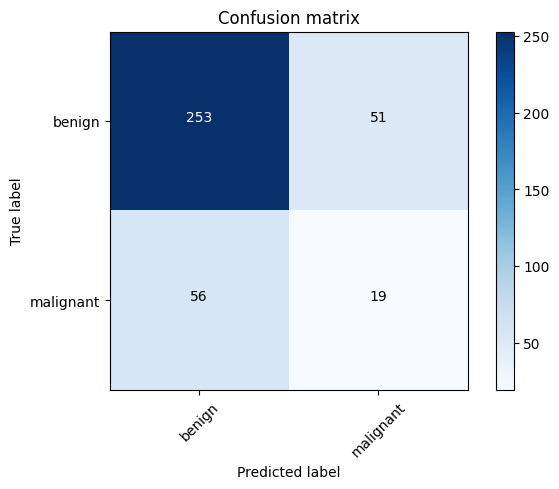

In [7]:
calibration_utils.plot_confusion_matrix(confusion_matrix(np_gt, np_pred), ["benign", "malignant"])
# pprint(confusion_matrix(np_gt, np_pred))

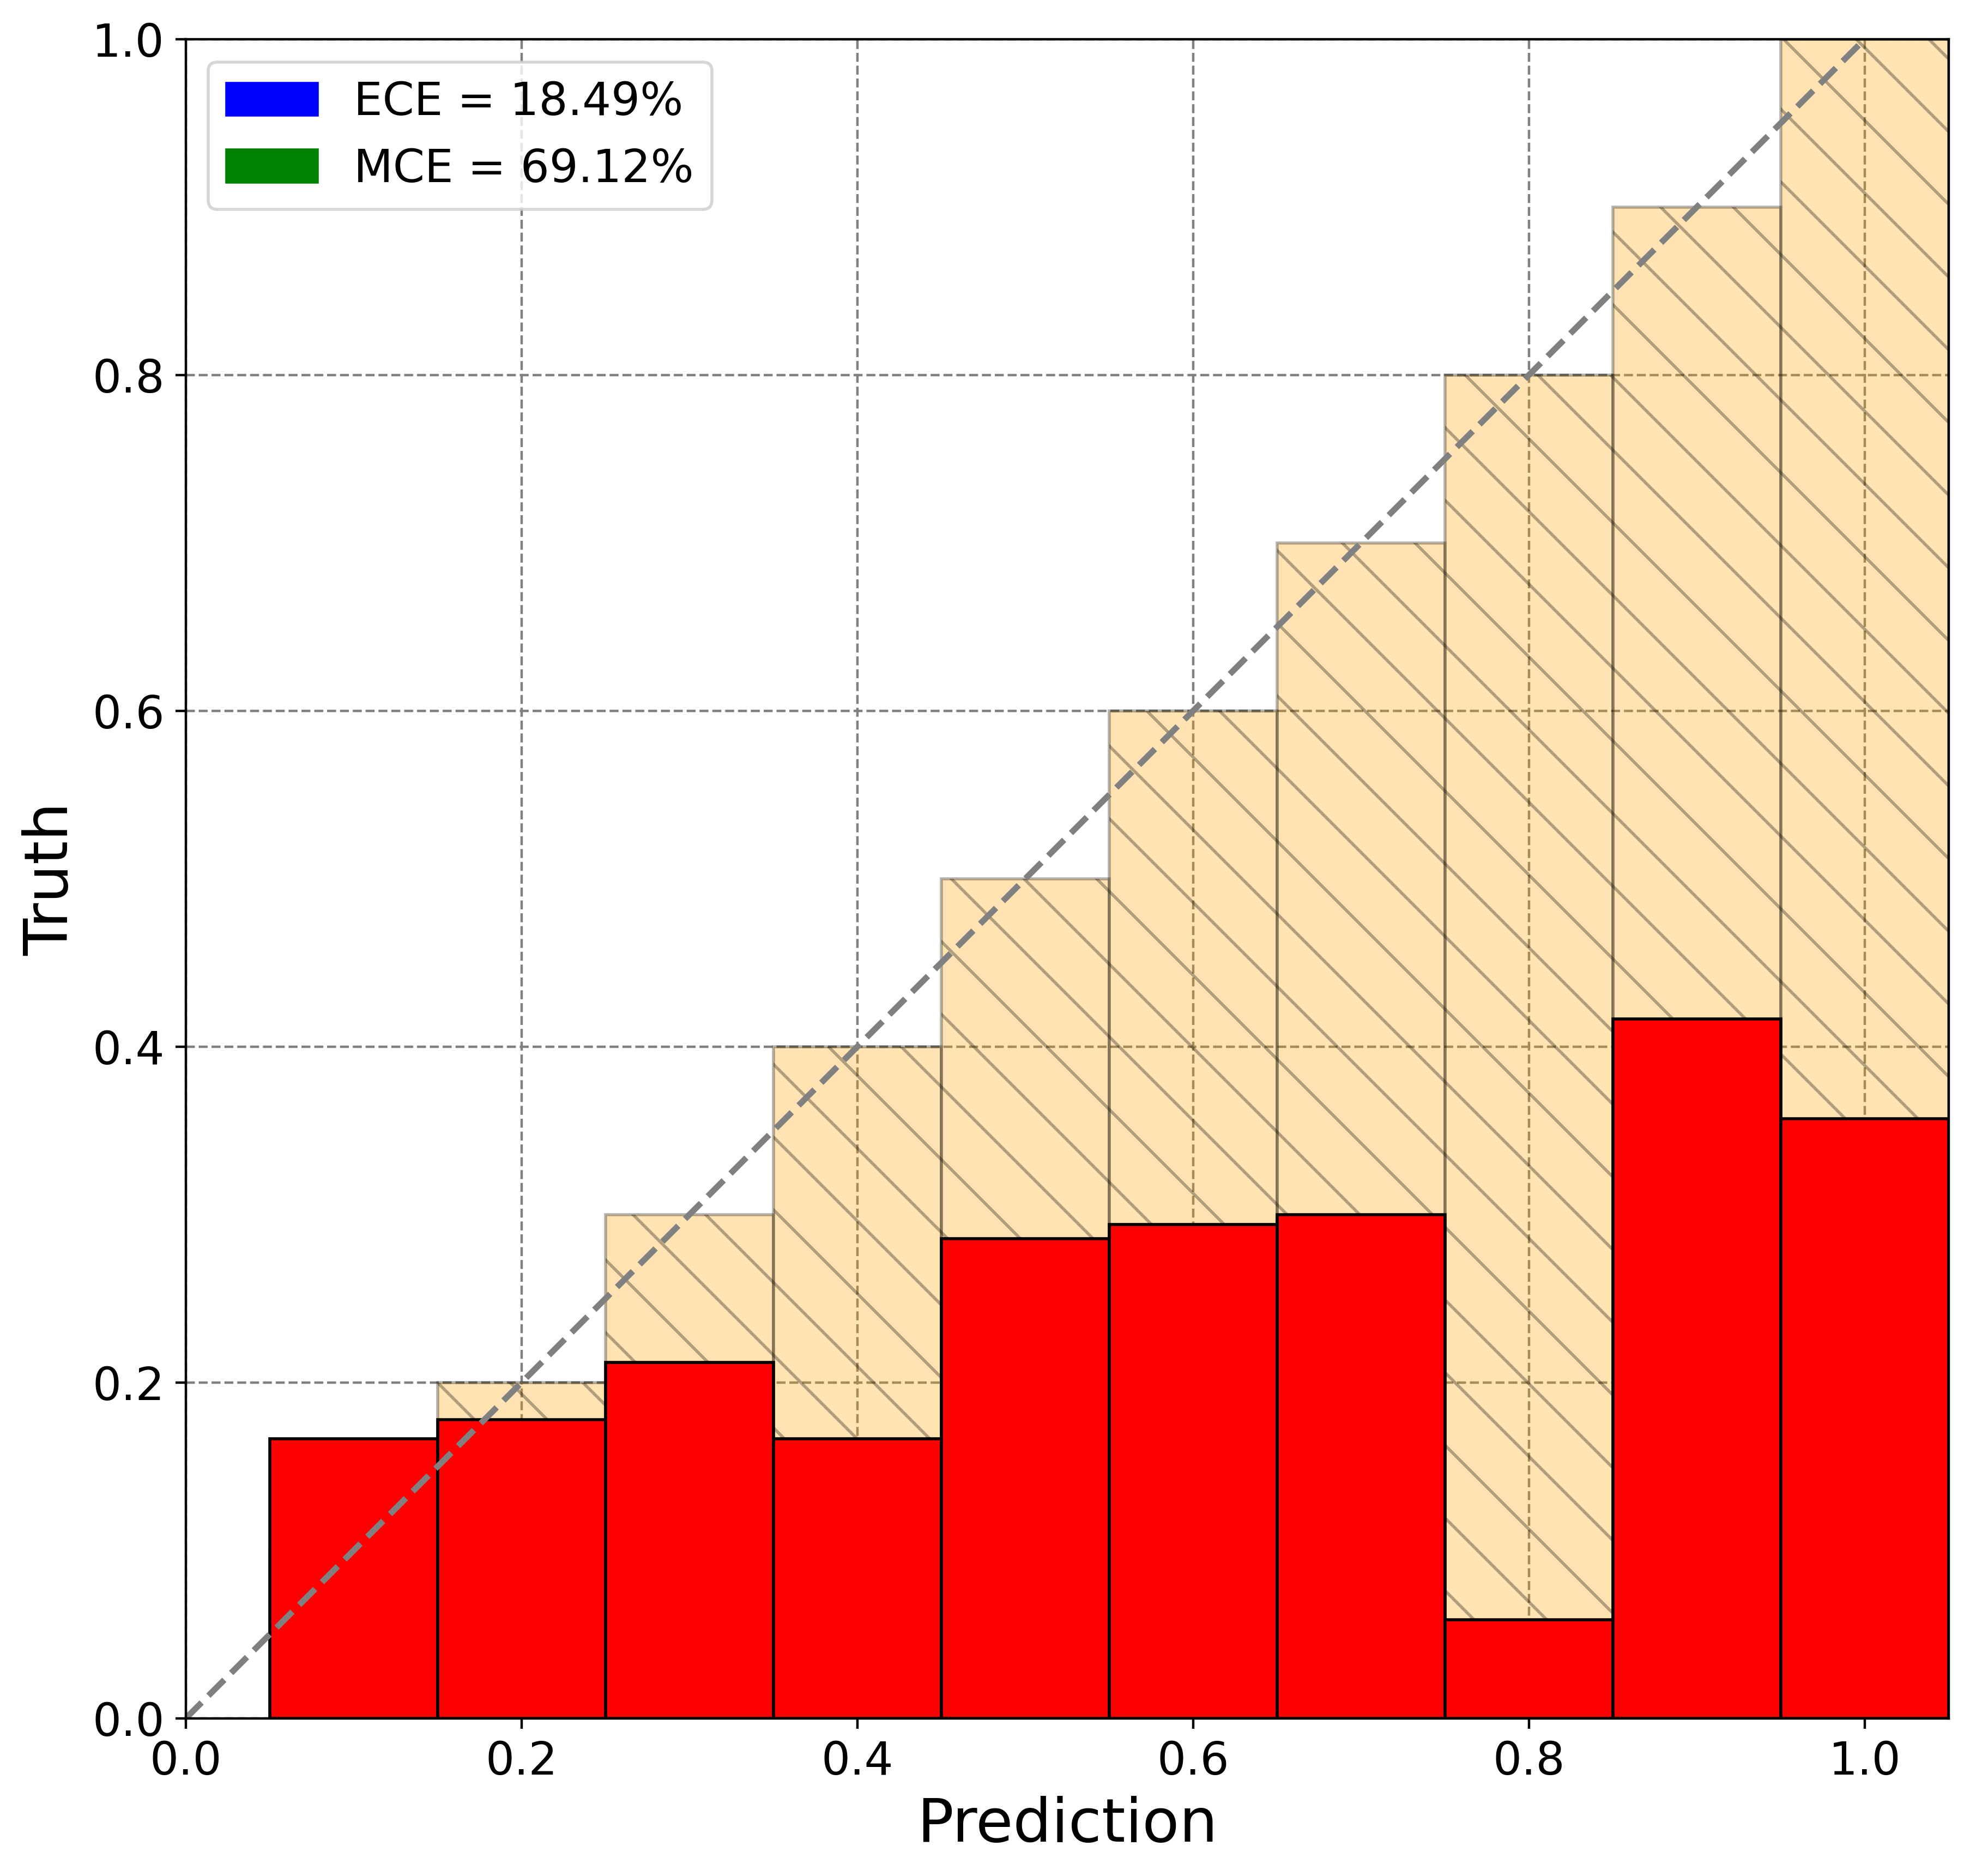

In [8]:
calibration_utils.draw_reliability_graph(np_gt, np_conf)

In [9]:
# conf_sort = np.sort(np_conf)
# print(np.sum((np_conf < 0.5)))
# plt.plot(conf_sort, marker='x')
# plt.show()
# plt.close()

In [10]:
metrics = calibration_utils.matrix_metrix(np_gt, np_pred, 1.0)
# pprint(metrics)

In [11]:
bins, binned, bin_accs, bin_confs, bin_sizes = calibration_utils.calc_bins(np_gt, np_conf)

In [12]:
np_gt_and_conf = np.hstack((np_gt.reshape((-1, 1)), np_conf.reshape((-1, 1))))
sorted_index = np.argsort(np_conf)
for row in np_gt_and_conf[sorted_index, :]:
    # print(f"{row[0]:.0f} | {row[1]:.2f}")
    None

In [13]:

bins = np.linspace(0.1, 1, 10)
binned = np.digitize(np_conf, bins)

In [14]:
bin_sizes = np.zeros(10)
bin_accs_2 = np.zeros(10)
for bin in range(10):
   bin_sizes[bin] = len(np_conf[binned == bin])
   if bin_sizes[bin] > 0:
      # bin_confs[bin] = (preds[binned==bin]).sum() / bin_sizes[bin]
      bin_accs_2[bin] = (np_gt[binned==bin].sum()) / bin_sizes[bin]
print(bin_accs, bin_accs_2)

[0.16666667 0.17777778 0.21212121 0.16666667 0.28571429 0.29411765
 0.3        0.05882353 0.41666667 0.35714286] [0.16666667 0.17777778 0.21212121 0.16666667 0.28571429 0.29411765
 0.3        0.05882353 0.41666667 0.35714286]
